# Logistic Regression

We will use the [Urine dataset](http://vincentarelbundock.github.io/Rdatasets/doc/boot/urine.html) to predict the presence or absence of calcium oxalate crystals in urine given 7 other physical characteristics of the urine sample.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc3 as pm
import scipy.stats as stats
import statsmodels.api as sm

from scipy.special import expit

%matplotlib inline

In [2]:
import warnings
warnings.filterwarnings("ignore")

## Load data

In [3]:
try:
    urine_df = pd.read_csv("urine.csv", index=False)
except:
    urine_df = pd.read_csv("http://vincentarelbundock.github.io/Rdatasets/csv/boot/urine.csv")
    urine_df.to_csv("urine.csv")
    
urine_df.head()

,Unnamed: 0,r,gravity,ph,osmo,cond,urea,calc
0,1,0,1.021,4.91,725.0,NaN,443,2.45
1,2,0,1.017,5.74,577.0,20.0,296,4.49
2,3,0,1.008,7.20,321.0,14.9,101,2.36
3,4,0,1.011,5.51,408.0,12.6,224,2.15
4,5,0,1.005,6.52,187.0,7.5,91,1.16


## Remove Missing Data

In [4]:
urine_df.dropna(inplace=True)
urine_df.head()

,Unnamed: 0,r,gravity,ph,osmo,cond,urea,calc
1,2,0,1.017,5.74,577.0,20.0,296,4.49
2,3,0,1.008,7.20,321.0,14.9,101,2.36
3,4,0,1.011,5.51,408.0,12.6,224,2.15
4,5,0,1.005,6.52,187.0,7.5,91,1.16
5,6,0,1.020,5.27,668.0,25.3,252,3.34


## Visualize Data

Findings from pairwise scatter plot:
* several of these variables are strongly correlated with one another, for example: `gravity` and `osmo`.
* collinearity is a problem in linear models, because these variables will compete with one another to **explain the response variable** leading to unstable estimation.
* collinearity is **not a problem for prediction**, so if prediction is the only goal, collinearity is not a problem.

Ways to deal with collinearity.
* Fit several models with different variables and use Deviance Information Criterion (DIC) to figure out the best one.
* The other way to do this is to have priors for the linear coefficients be close to 0. That way the burden of establishing the relation lies with the data rather than the prior. Rather than tailoring a prior, we convert the data to corresponding z-scores.

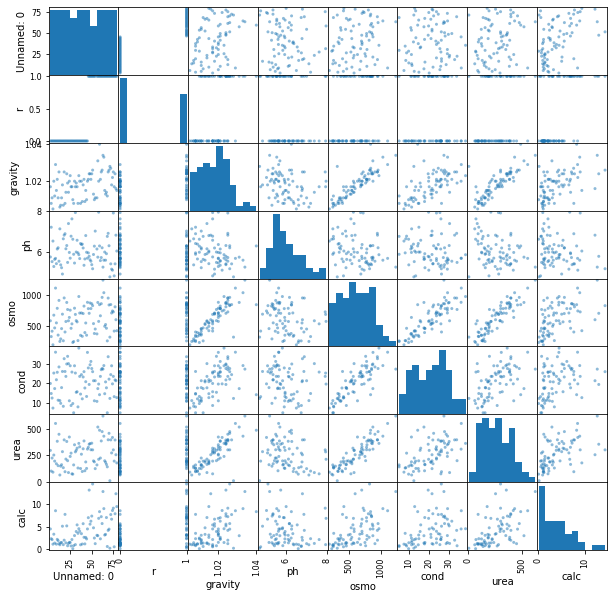

In [5]:
_ = pd.plotting.scatter_matrix(urine_df, diagonal="hist", figsize=(10,10))

## Predict Logit of Response Variable

As seen below, the response variable can be either 0 or 1, so a linear fit (blue line) is not ideal. What does seem to work is fitting the response variable against the logit function (red curve), which is given as follows:

$$ logit(y) = \frac{1}{1 + e^{-y}} $$

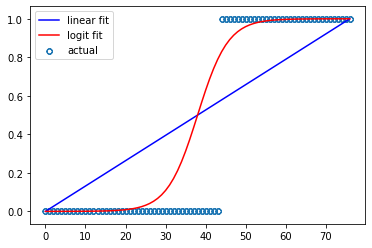

In [6]:
xs = np.arange(len(urine_df))
plt.scatter(np.arange(len(urine_df)), urine_df["r"].values, marker="$\u25EF$", label="actual")


ys_lin = 0.5 + (xs - np.mean(xs)) / np.max(xs)
plt.plot(xs, ys_lin, color="b", label="linear fit")

xs_expit = 20 * (xs - np.mean(xs)) / np.max(xs)
plt.plot(xs, expit(xs_expit), color="r", label="logit fit")

plt.legend(loc="best")

_ = plt.show()

## Standardize the data

One of our strategies is to choose a prior for the coefficients of the explanatory variables close to 0. However, unless we make all the data to be at the same scale, this will not work because the coefficients would need to be tuned for each range. Standardizing transforms each column into a distribution with mean 0 and standard deviation 1.

$$ z = \frac{x - \overline{x}}{\sigma} $$

In [7]:
X = urine_df.values[:, 2:]
y = urine_df.values[:, 1]
X.shape, y.shape

((77, 6), (77,))

In [8]:
X_mean = np.mean(X, axis=0)
X_std = np.std(X, axis=0)
X_norm = (X - X_mean) / X_std

In [9]:
print("Means close to 0?", np.isclose(np.mean(X_norm, axis=0), np.zeros(X_norm.shape[1])))
print("S.D.  close to 1?", np.isclose(np.std(X_norm, axis=0), np.ones(X_norm.shape[1])))

Means close to 0? [ True  True  True  True  True  True]
S.D.  close to 1? [ True  True  True  True  True  True]


## Choose Prior Distribution close to zero

We choose a double exponential distribution, also called a Laplace distribution. It has a sharp peak at 0.

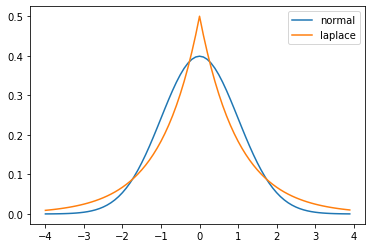

In [10]:
xs = np.arange(-4, 4, 0.1)
plt.plot(xs, stats.norm.pdf(xs, loc=0, scale=1), label="normal")
plt.plot(xs, stats.laplace.pdf(xs, loc=0, scale=1), label="laplace")
plt.legend(loc="best")
_ = plt.show()

## Model 1

We build a baseline model with all coefficients.

In [11]:
model_1 = pm.Model()
with model_1:
    coeff_int = pm.Normal("coeff_int", mu=0, sigma=5)  # fairly non-informative for logistic regression
    coeffs = pm.Laplace("coeffs", mu=0, b=np.sqrt(0.5), shape=6)
    
    logit_pred = (coeff_int + 
                  coeffs[0] * X_norm[:, 0] + coeffs[1] * X_norm[:, 1] + 
                  coeffs[2] * X_norm[:, 2] + coeffs[3] * X_norm[:, 3] + 
                  coeffs[4] * X_norm[:, 4] + coeffs[5] * X_norm[:, 5])
    
    y_obs = pm.Bernoulli("y_obs", p=pm.math.invlogit(logit_pred), observed=y)
    
    trace_1 = pm.sample(5000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [coeffs, coeff_int]
Sampling 4 chains, 0 divergences: 100%|██████████| 24000/24000 [00:23<00:00, 1004.93draws/s]


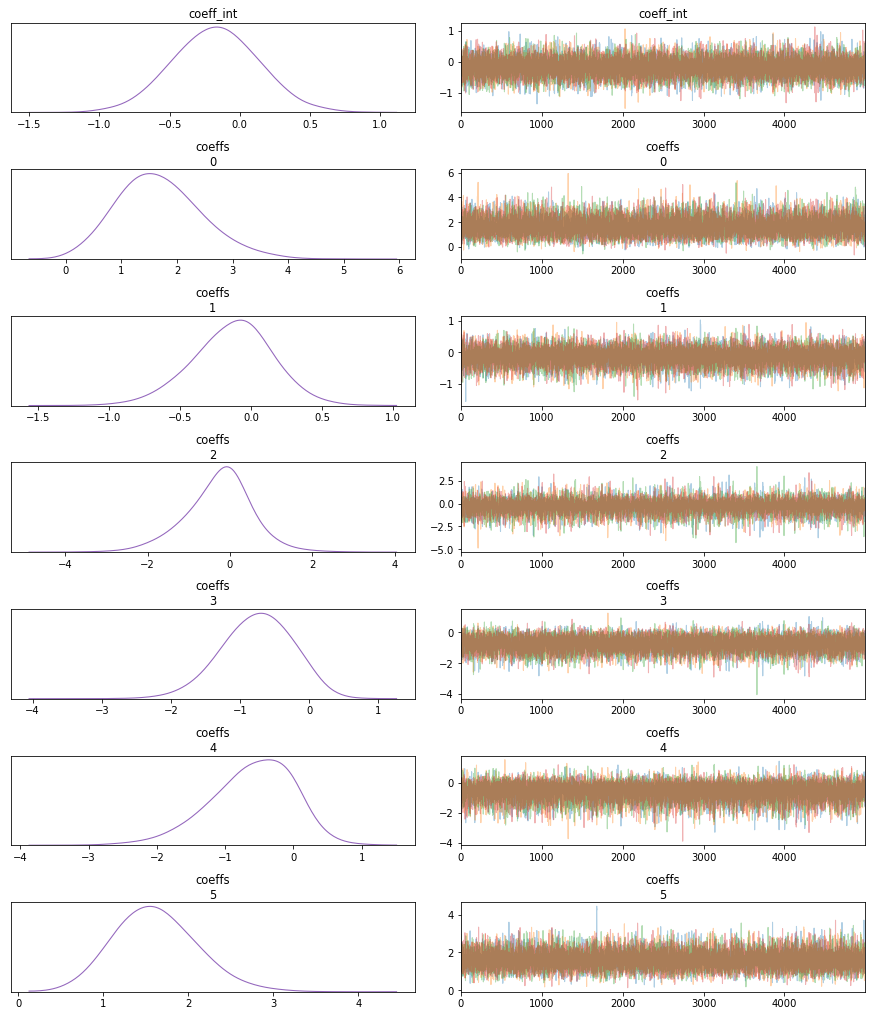

In [12]:
_ = pm.traceplot(trace_1, combined=True, compact=False)

In [13]:
pm.summary(trace_1)

,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
coeff_int,-0.178,0.306,-0.763,0.380,0.002,0.002,18767.0,11556.0,18773.0,13975.0,1.0
coeffs[0],1.675,0.756,0.298,3.111,0.007,0.005,11681.0,10118.0,12272.0,11771.0,1.0
coeffs[1],-0.140,0.282,-0.681,0.387,0.002,0.002,17811.0,9228.0,18196.0,12522.0,1.0
coeffs[2],-0.288,0.798,-1.960,1.120,0.007,0.007,11375.0,7299.0,12161.0,10231.0,1.0
coeffs[3],-0.768,0.506,-1.749,0.109,0.005,0.003,12460.0,11114.0,12672.0,12685.0,1.0
coeffs[4],-0.622,0.608,-1.797,0.421,0.006,0.004,11778.0,9424.0,12777.0,10988.0,1.0
coeffs[5],1.610,0.486,0.719,2.535,0.004,0.003,16085.0,14316.0,16615.0,13203.0,1.0


## Model 2

Findings from traceplot for Model 1:

* The posterior distribution of most of the coefficients are not centered around zero, that signals that they have some effect.
* Posterior distribution for `coeffs[1] (ph)` and `coeffs[2] (osmo)` are centered around 0 and their shape looks almost identical to the double exponential prior. 
* Posterior distribution for `coeffs[4] (urea)` is also centered around 0 but not as strongly as the previous 2. However, from the pairs plot above, `urea` looks strongly correlated with `gravity`

Hence our new model will drop the coefficients for `ph`, `osmo`, and `urea`. We will also switch from the Laplace prior to a Normal prior for this model.

Findings from summary of Model 2:
* probability of calcium oxalate crystal formation in urine is 1.4x likely for each unit increase in specific gravity.
* probability of calcium oxalate crystal formation in urine is 1.33x likely for each unit decrease in conductivity.
* probability of calcium oxalate crystal formation in urine is 1.85x likely for each unit increase in calcium

These probabilities are several standard deviations away from 0 so they are significant.

In [14]:
model_2 = pm.Model()
with model_2:
    coeff_int = pm.Normal("coeff_int", mu=0, sigma=5)
    coeffs = pm.Normal("coeffs", mu=0, sigma=5, shape=3)
    
    logit_pred = (coeff_int + 
                  coeffs[0] * X_norm[:, 0] + 
                  coeffs[1] * X_norm[:, 3] + 
                  coeffs[2] * X_norm[:, 5])
    
    y_obs = pm.Bernoulli("y_obs", p=pm.math.invlogit(logit_pred), observed=y)
    
    trace_2 = pm.sample(5000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [coeffs, coeff_int]
Sampling 4 chains, 0 divergences: 100%|██████████| 24000/24000 [00:14<00:00, 1614.87draws/s]


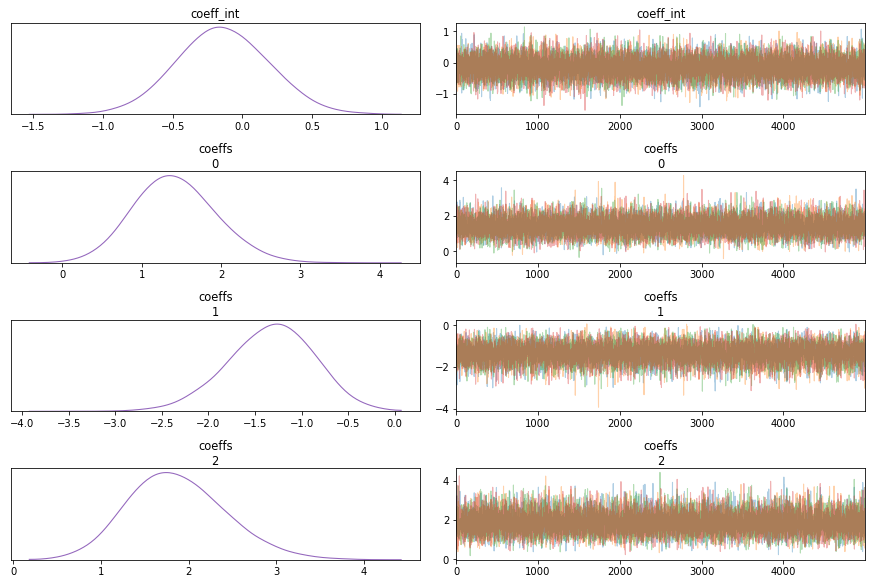

In [15]:
_ = pm.traceplot(trace_2, combined=True, compact=False)

In [16]:
pm.summary(trace_2)

,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
coeff_int,-0.147,0.328,-0.758,0.471,0.003,0.002,15431.0,12114.0,15458.0,14260.0,1.0
coeffs[0],1.413,0.514,0.471,2.392,0.005,0.003,13017.0,12080.0,13202.0,12628.0,1.0
coeffs[1],-1.342,0.460,-2.218,-0.500,0.004,0.003,10734.0,10380.0,10794.0,12334.0,1.0
coeffs[2],1.864,0.551,0.875,2.931,0.005,0.004,12097.0,11321.0,12418.0,12183.0,1.0


## Compare models

Even though the first model is better in terms of WAIC, they are very close. The second model has fewer variables, and is easier to explain.

In [17]:
compare_dict = {
    "model_1": trace_1,
    "model_2": trace_2
}
pm.compare(compare_dict)

,rank,waic,p_waic,d_waic,weight,se,dse,warning,waic_scale
model_1,0,73.4364,4.48217,0,0.655988,8.60203,0,True,deviance
model_2,1,75.6731,4.13777,2.23668,0.344012,10.6676,3.55819,True,deviance


## Predicting from Model

We are predicting the probability of the response, which is the inverse of the logit of the response variable.

$$ E(y_i) = p_i = \frac{1}{1 + e^{-\beta_0 - \beta_ix_i}} $$

### Specific cases

When `gravity`, `cond`, and `calc` are all at average values, the probability of urine containing calcium oxalate crystals are given as:

In [18]:
1 / (1 + np.exp(0.154))

0.4615759088130736

When `gravity` has average value, but `cond` is one SD below mean, `calc` is one SD above mean, the probability of urine containing calcium oxalate crystals is given by:

In [19]:
1 / (1 + np.exp(0.154 - 1.329 - 1.851))

0.9537349947323173

### Bulk predictions

We will compute predictions over the entire `urine` dataset (ideally we would be doing this for an unseen test set).

In [20]:
coeff_int = np.array([np.mean(trace_2.get_values("coeff_int"))])
coeffs_other = np.mean(trace_2.get_values("coeffs", combine=True), axis=0)
coeffs = np.hstack((coeff_int, coeffs_other))

ones = np.ones(X_norm.shape[0])
gravity = X_norm[:, 0]
cond = X_norm[:, 3]
calc = X_norm[:, 5]
X_test = np.vstack((ones, gravity, cond, calc))

preds = np.matmul(coeffs, X_test)
probs = expit(preds)

## Residual Plot of Predictions

Shows that model predicted low probabilites for rows with `r=0` and high probabilities for most of the rows with `r=1`.

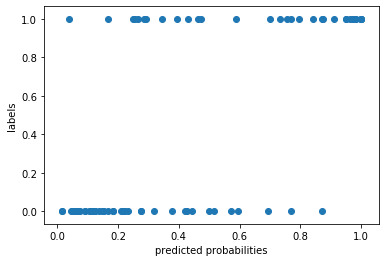

In [21]:
plt.scatter(probs, y)
plt.xlabel("predicted probabilities")
plt.ylabel("labels")
_ = plt.show()

### Threshold at p=0.5

In [22]:
r_pred = pd.Series([1.0 if x > 0.5 else 0.0 for x in probs], name="r_pred")
r = urine_df["r"]
conf_matrix_at_50 = pd.crosstab(r, r_pred)
conf_matrix_at_50

r_pred,0.0,1.0
r,,
0,37,7
1,12,19


In [23]:
M = conf_matrix_at_50.values
acc_at_50 = np.sum(np.diag(M)) / np.sum(M)
acc_at_50

0.7466666666666667

### Threshold at p=0.2

Based on business requirement that not predicting calcium oxalate when there may be is worse than predicting calcium oxalate when there is not.

We will take a hit to overall accuracy to increase our chances of detecting a true positive and reduce our chance of detecting a false negative.

In [24]:
r_pred = pd.Series([1.0 if x > 0.2 else 0.0 for x in probs], name="r_pred")
r = urine_df["r"]
conf_matrix_at_20 = pd.crosstab(r, r_pred)
conf_matrix_at_20

r_pred,0.0,1.0
r,,
0,26,18
1,2,29


In [25]:
M = conf_matrix_at_20.values
acc_at_20 = np.sum(np.diag(M)) / np.sum(M)
acc_at_20

0.7333333333333333

### Receiving Operating Characteristics (ROC) Curve

Repeat above calculation for multiple points and plot.

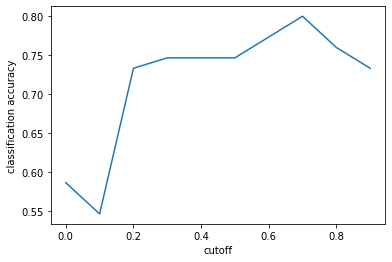

In [26]:
accuracies = []
thresholds = np.arange(0, 1, 0.1)
r_labels = urine_df["r"]
for threshold in thresholds:
    r_preds = pd.Series([1.0 if x > threshold else 0.0 for x in probs], name="r_pred")
    conf_matrix = pd.crosstab(r_labels, r_preds)
    M = conf_matrix.values
    accuracy = np.sum(np.diag(M)) / np.sum(M)
    accuracies.append(accuracy)
    
plt.plot(thresholds, accuracies)
plt.xlabel("cutoff")
plt.ylabel("classification accuracy")
_ = plt.show()

## References

* [GLM: Logistic Regression](https://docs.pymc.io/notebooks/GLM-logistic.html) -- another case study from PyMC3 documentation, with a different approach to logistic regression.